In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Load the dataset
df = pd.read_csv('src/merge_cmu.csv')

# Display the first few rows of the dataframe
print(df.head())

# Display basic information about the dataframe
print(df.info())

# Display summary statistics of the dataframe
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Display the column names
print(df.columns)

         movie_name  movie_date   box_office  runtime  \
0       marypoppins        1964  102272727.0    139.0   
1  mysteriousisland        1982          NaN    100.0   
2            juarez        1939          NaN    125.0   
3   thegreatsantini        1979    4702575.0    115.0   
4         thecastle        1968          NaN     88.0   

                             language                 countries  \
0                    English Language  United States of America   
1                   Standard Mandarin                 Hong Kong   
2  English Language, Spanish Language  United States of America   
3                    English Language  United States of America   
4                     German Language              West Germany   

                                              genres  \
0  Children's/Family, Musical, Fantasy, Comedy, D...   
1  Action/Adventure, Wuxia, Martial Arts Film, Ch...   
2  Costume drama, Biographical film, Historical f...   
3                             

In [87]:
# Separate the genres by each comma and explode the list into separate rows
df['genres'] = df['genres'].str.split(', ')
df_genres_exploded = df.explode('genres')

# Group by 'genres' and count the number of movies in each genre
genre_counts = df_genres_exploded['genres'].value_counts()

# Get the unique genres from the dataframe
genres_unique = df_genres_exploded['genres'].unique()

In [88]:
# Define the mapping of genres to broader movie categories
genre_categories = {
    "Family & Children": [
        "Children's/Family", "Family Film", "Children's Fantasy", "Family Drama", 
        "Children's", "Children's Entertainment", "Holiday Film", "Family-Oriented Adventure"
    ],
    "Fantasy & Science Fiction": [
        "Fantasy", "Fantasy Adventure", "Sword and sorcery", "Fantasy Comedy", 
        "Romantic fantasy", "Mythological Fantasy", "Science Fiction", "Sci-Fi Horror", 
        "Sci-Fi Adventure", "Space opera", "Alien Film", "Time travel", "Cyberpunk", "Steampunk", 
        "Werewolf fiction", "Natural disaster", "Fantasy Horror", "Fairy tale", "Fantasy Drama"
    ],
    "Comedy": [
        "Comedy", "Comedy film", "Comedy-drama", "Slapstick", "Tragicomedy", "Screwball comedy", 
        "Black comedy", "Workplace Comedy", "Comedy of manners", "Comedy Thriller", "Fantasy Comedy", 
        "Political satire", "Musical comedy", "Comedy Western", "Sex comedy"
    ],
    "Drama": [
        "Drama", "Romantic drama", "Family Drama", "Marriage Drama", "Erotic Drama", 
        "Romantic fantasy", "Romantic comedy", "Heavenly Comedy", "Addiction Drama", "Medical fiction", 
        "Domestic Comedy", "Legal drama", "Childhood Drama", "Psychological drama", "Addiction Drama",
        "Fantasy Drama"
    ],
    "Action & Adventure": [
        "Action/Adventure", "Action", "Adventure", "Action Thrillers", "Adventure Comedy", 
        "Swashbuckler films", "Chase Movie", "Combat Films", "War film", "Heist", 
        "Caper story", "Western", "Epic Western", "Indian Western", "Baseball", 
        "Parkour in popular culture", "Escape Film", "Movie serial", "Fantasy Adventure", 
        "Sword and sorcery"
    ],
    "Historical & Period Films": [
        "Historical fiction", "Biographical film", "Costume drama", "Period piece", 
        "Historical drama", "Historical Epic", "History", "Historical drama", 
        "British Empire Film", "The Netherlands in World War II", "Film adaptation", 
        "Film à clef", "Roadshow theatrical release", "British New Wave", "Melodrama", 
        "Costume Horror", "Epic", "Archaeology", "Americana"
    ],
    "Musicals & Dance": [
        "Musical", "Animated Musical", "Dance", "Musical comedy", "Musical Drama", "Music", "Hip hop movies"
    ],
    "Horror & Supernatural": [
        "Horror", "Supernatural", "Horror Comedy", "Psychological horror", "Slasher", 
        "Creature Film", "Haunted House Film", "Monster", "Monster movie", 
        "Zombie Film", "Demonic child", "Natural horror films", "Plague", "Sexploitation",
        "Werewolf fiction", "Psycho-biddy", "Gothic Film"
    ],
    "Romance & Relationship Films": [
        "Romance Film", "Romantic drama", "Romantic comedy", "Family Drama", 
        "Marriage Drama", "Erotic Drama", "Romantic fantasy", "Romantic comedy", 
        "Heavenly Comedy", "Fantasy romance", "Tragedy"
    ],
    "Thrillers & Mysteries": [
        "Thriller", "Mystery", "Detective", "Crime Thriller", "Suspense", "Crime Fiction", 
        "Detective fiction", "Whodunit", "Crime Drama", "Crime Comedy", 
        "Psychological thriller", "Erotic thriller", "Neo-noir", "Future noir", "Spy", 
        "Glamourized Spy Film", "Remake", "Buddy film", "Legal drama", "Political thriller", "Action Thrillers",
        "Glamorized Spy Film"
    ],
    "Indie & Art": [
        "Indie", "Art film", "Experimental film", "Avant-garde", "Foreign legion", "Art house", 
        "Documentary", "New Hollywood", "Experimental film", "Cult", "Mockumentary", "Short Film"
    ],
    "Animated": [
        "Animated cartoon", "Animation", "Computer Animation", "Stop motion", "Anime"
    ],
    "Cultural & World": [
        "Chinese Movies", "World cinema", "Japanese Movies", "Bengali Cinema", 
        "Filipino Movies", "Bollywood", "The Netherlands in World War II", "Indian Western", "Americana"
    ],
    "Biographical & Based on True Stories": [
        "Biopic [feature]", "Docudrama", "Biography", "Hagiography", "Courtroom Drama"
    ],
    "Crime & Gangster": [
        "Gangster Film", "Crime Fiction", "Crime Drama", "Blaxploitation", "Heist", 
        "Caper story", "Gangster movie", "Prison film", "B-movie", "Crime Comedy", "Caper story", "Prison",
        "Crime Thriller"
    ],
    "War & Military": [
        "War film", "Anti-war", "Military fiction", "Combat Films", "Cold War", 
        "Revisionist Western", "Cavalry Film", "The Netherlands in World War II", "Disaster", 
        "Propaganda film", "Doomsday film", "Anti-war film"
    ],
    "Comedy of Errors & Parodies": [
        "Parody", "Comedy of Errors", "Satire", "Black comedy", "Screwball comedy", 
        "Comedy of manners", "Comedy Thriller", "Fantasy Comedy", "Sex comedy", 
        "Parody", "Sexploitation", "Domestic Comedy"
    ],
    "Cult & Experimental": [
        "Cult", "Avant-garde", "Experimental film", "Surrealism", "Absurdism", 
        "Kafkaesque", "Expressionism", "Sexploitation", "Film noir", "Nan"
    ],
    "Documentary & Non-fiction": [
        "Documentary", "Educational", "Archives and records", "Political cinema", "Anthology", "Natural disaster",
        "Animal Picture", "Jungle Film", "Nature documentary", "Airplanes and airports"
    ],
    "Teen & Coming of Age": [
        "Coming of age", "Teen", "Juvenile Delinquency Film", "School story", "Slice of life story",
        "Childhood Drama"
    ],
    "Science Fiction & Fantasy": [
        "Science Fiction", "Sword and sorcery", "Mythological Fantasy", "Fantasy Adventure", 
        "Space opera", "Cyberpunk", "Alien invasion", "Sci-Fi Horror", "Dystopia", "Werewolf fiction"
    ],
    "Social Issues & Political Drama": [
        "Political drama", "Political thriller", "Social problem film", "Political cinema", 
        "Feminist Film", "Christian film", "Social commentary", "Addiction Drama", "Anti-war film"
    ],
    "Holiday & Seasonal": [
        "Christmas movie", "Holiday Film"
    ],
    "Psychological & Mind-bending": [
        "Psychological thriller", "Existentialism", "Surrealism", "Psychological horror", 
        "Mind-bending film", "Heavenly Comedy", "Psycho-biddy"
    ],
    "Superhero": [
        "Superhero movie", "Superhero"
    ],
    "Genre-Bending": [
        "Hybrid Western", "Action Comedy", "Fantasy Drama", "Horror Comedy", "Sci-Fi Adventure", 
        "Road movie", "Epic Western"
    ],
    "Social Commentary & Drama": [
        "Social problem film", "Feminist Film", "Kitchen sink realism", "Slice of life", "Tragicomedy", "Albino bias"
    ],
    "B-Movies & Cult": [
        "B-movie", "Horror B-movie", "Grindhouse", "Sexploitation", "Caper story", "B-Western", 
        "Reboot", "Sexploitation"
    ],
    "Period & Costume": [
        "Costume drama", "Period piece", "Historical drama", "Costume Adventure", "Epic",
        "Costume Horror"
    ],
    "Classic & Silent": [
        "Black-and-white", "Silent film", "Pre-Code", "Film noir"
    ],
    "Cyber & Digital": [
        "Cyberpunk", "Digital drama", "Computer Animation"
    ],
    "Espionage & Spy": [
        "Spy", "Glamourized Spy Film", "Political thriller", "Glamorized Spy Film"
    ],
    "Zombie & Apocalyptic": [
        "Zombie Film", "Apocalyptic and post-apocalyptic fiction", "Doomsday film"
    ],
    "Cult Classics & Experimental": [
        "Cult", "Experimental film"
    ],
    "Historical Epics": [
        "Historical Epic", "Period drama"
    ],
    "Epic Western": [
        "Epic Western", "Revisionist Western"
    ],
    "Sports & Martial Arts": [
        "Sports", "Baseball", "Horse racing", "Stoner film", "Beach Film", "Parkour in popular culture",
        "Wuxia", "Martial Arts Film", "Samurai cinema", "Sword and Sandal", 
        "Kung Fu films", "Sword and sorcery films"
    ],
    "LGBTQ+": [
        "LGBT", "Gay", "Gay Interest", "Gay Themed", "LGBT", "Gay pornography"
    ],
    "Adult & Erotic": [
        "Erotica", "Adult", "Softcore Porn", "Erotic Drama", "Sex comedy", "Sexploitation"
    ],
    "Other": [
        "Ensemble Film", "Star vehicle", "Television movie", "Female buddy film", "nan", ""
    ]
}


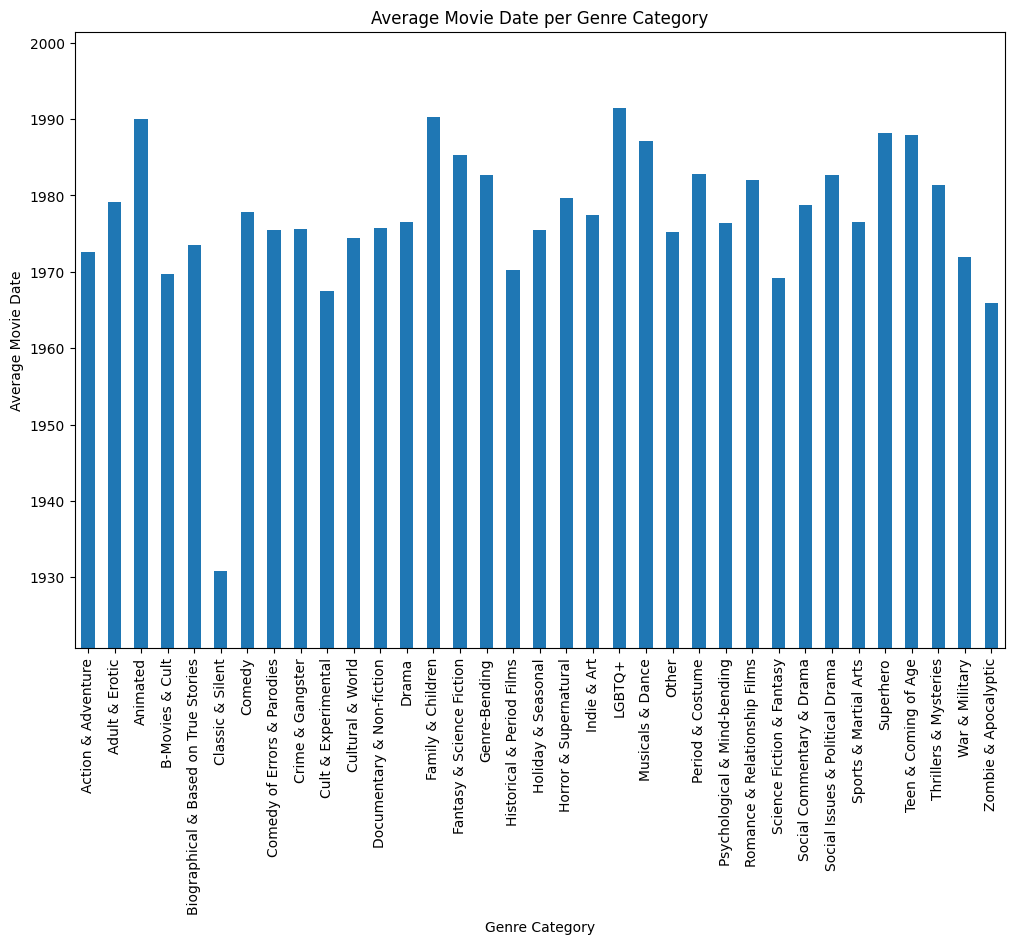

In [89]:
# Calculate the average movie date for each genre category
average_movie_date = df_genres_exploded.groupby('genres')['movie_date'].mean()

# Map genres to categories
average_movie_date_category = average_movie_date.reset_index()
average_movie_date_category['category'] = average_movie_date_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average movie date for each category
average_movie_date_category = average_movie_date_category.groupby('category')['movie_date'].mean()

# Plot the average movie date for each genre category
plt.figure(figsize=(12, 8))
average_movie_date_category.plot(kind='bar')
plt.title('Average Movie Date per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Movie Date')
plt.xticks(rotation=90)
plt.ylim(average_movie_date_category.min() - 10, average_movie_date_category.max() + 10)
plt.show()

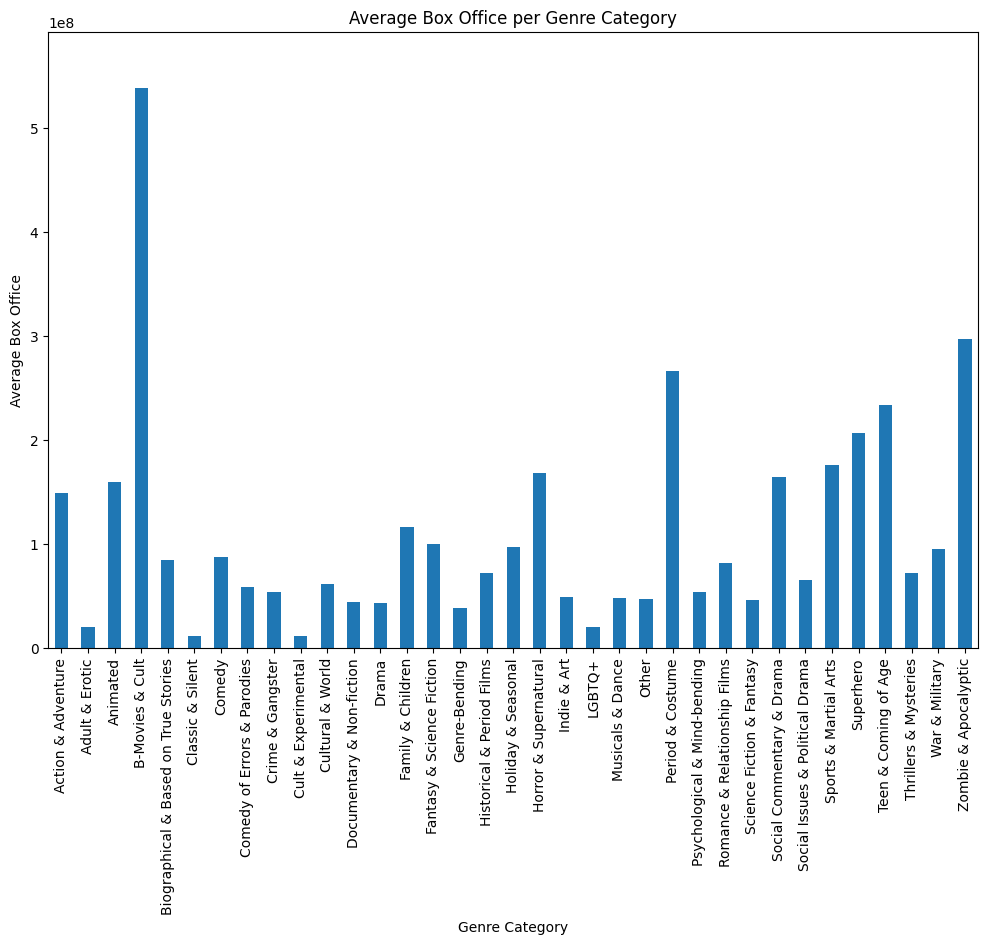

In [90]:
# Calculate the average box office for each genre category
average_box_office = df_genres_exploded.dropna(subset=['box_office']).groupby('genres')['box_office'].mean()

# Map genres to categories
average_box_office_category = average_box_office.reset_index()
average_box_office_category['category'] = average_box_office_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average box office for each category
average_box_office_category = average_box_office_category.groupby('category')['box_office'].mean()

# Plot the average box office for each genre category
plt.figure(figsize=(12, 8))
average_box_office_category.plot(kind='bar')
plt.title('Average Box Office per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Box Office')
plt.xticks(rotation=90)
plt.ylim(0, average_box_office_category.max() + average_box_office_category.max()/10)
plt.show()

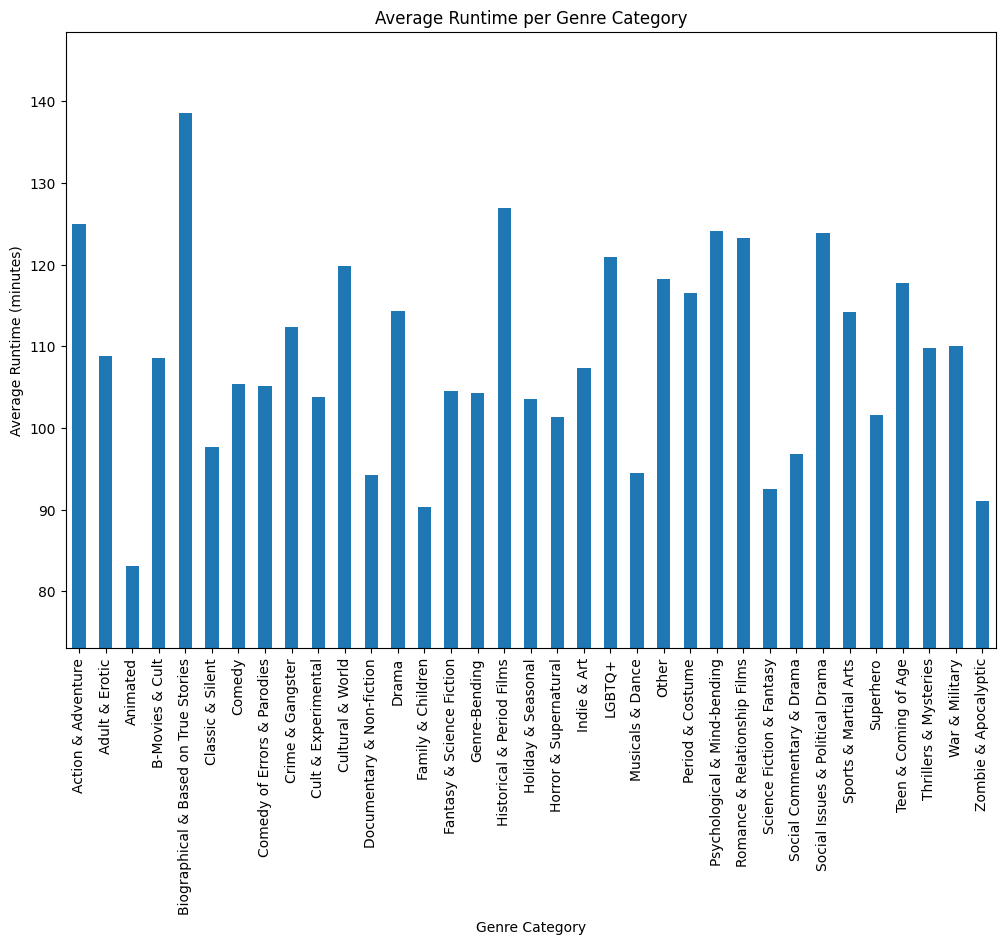

In [91]:
# Calculate the average runtime for each genre category
average_runtime = df_genres_exploded.dropna(subset=['runtime']).groupby('genres')['runtime'].mean()

# Map genres to categories
average_runtime_category = average_runtime.reset_index()
average_runtime_category['category'] = average_runtime_category['genres'].map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Calculate the average runtime for each category
average_runtime_category = average_runtime_category.groupby('category')['runtime'].mean()

# Plot the average runtime for each genre category
plt.figure(figsize=(12, 8))
average_runtime_category.plot(kind='bar')
plt.title('Average Runtime per Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Average Runtime (minutes)')
plt.xticks(rotation=90)
plt.ylim(average_runtime_category.min() - 10, average_runtime_category.max() + 10)
plt.show()

In [92]:
# Separate the languages by each comma and explode the list into separate rows
df_genres_exploded['language'] = df_genres_exploded['language'].str.split(', ')
df_genres_exploded_languages_exploded = df_genres_exploded.explode('language')

# Get the unique languages from the dataframe
languages_unique = df_genres_exploded_languages_exploded['language'].unique()

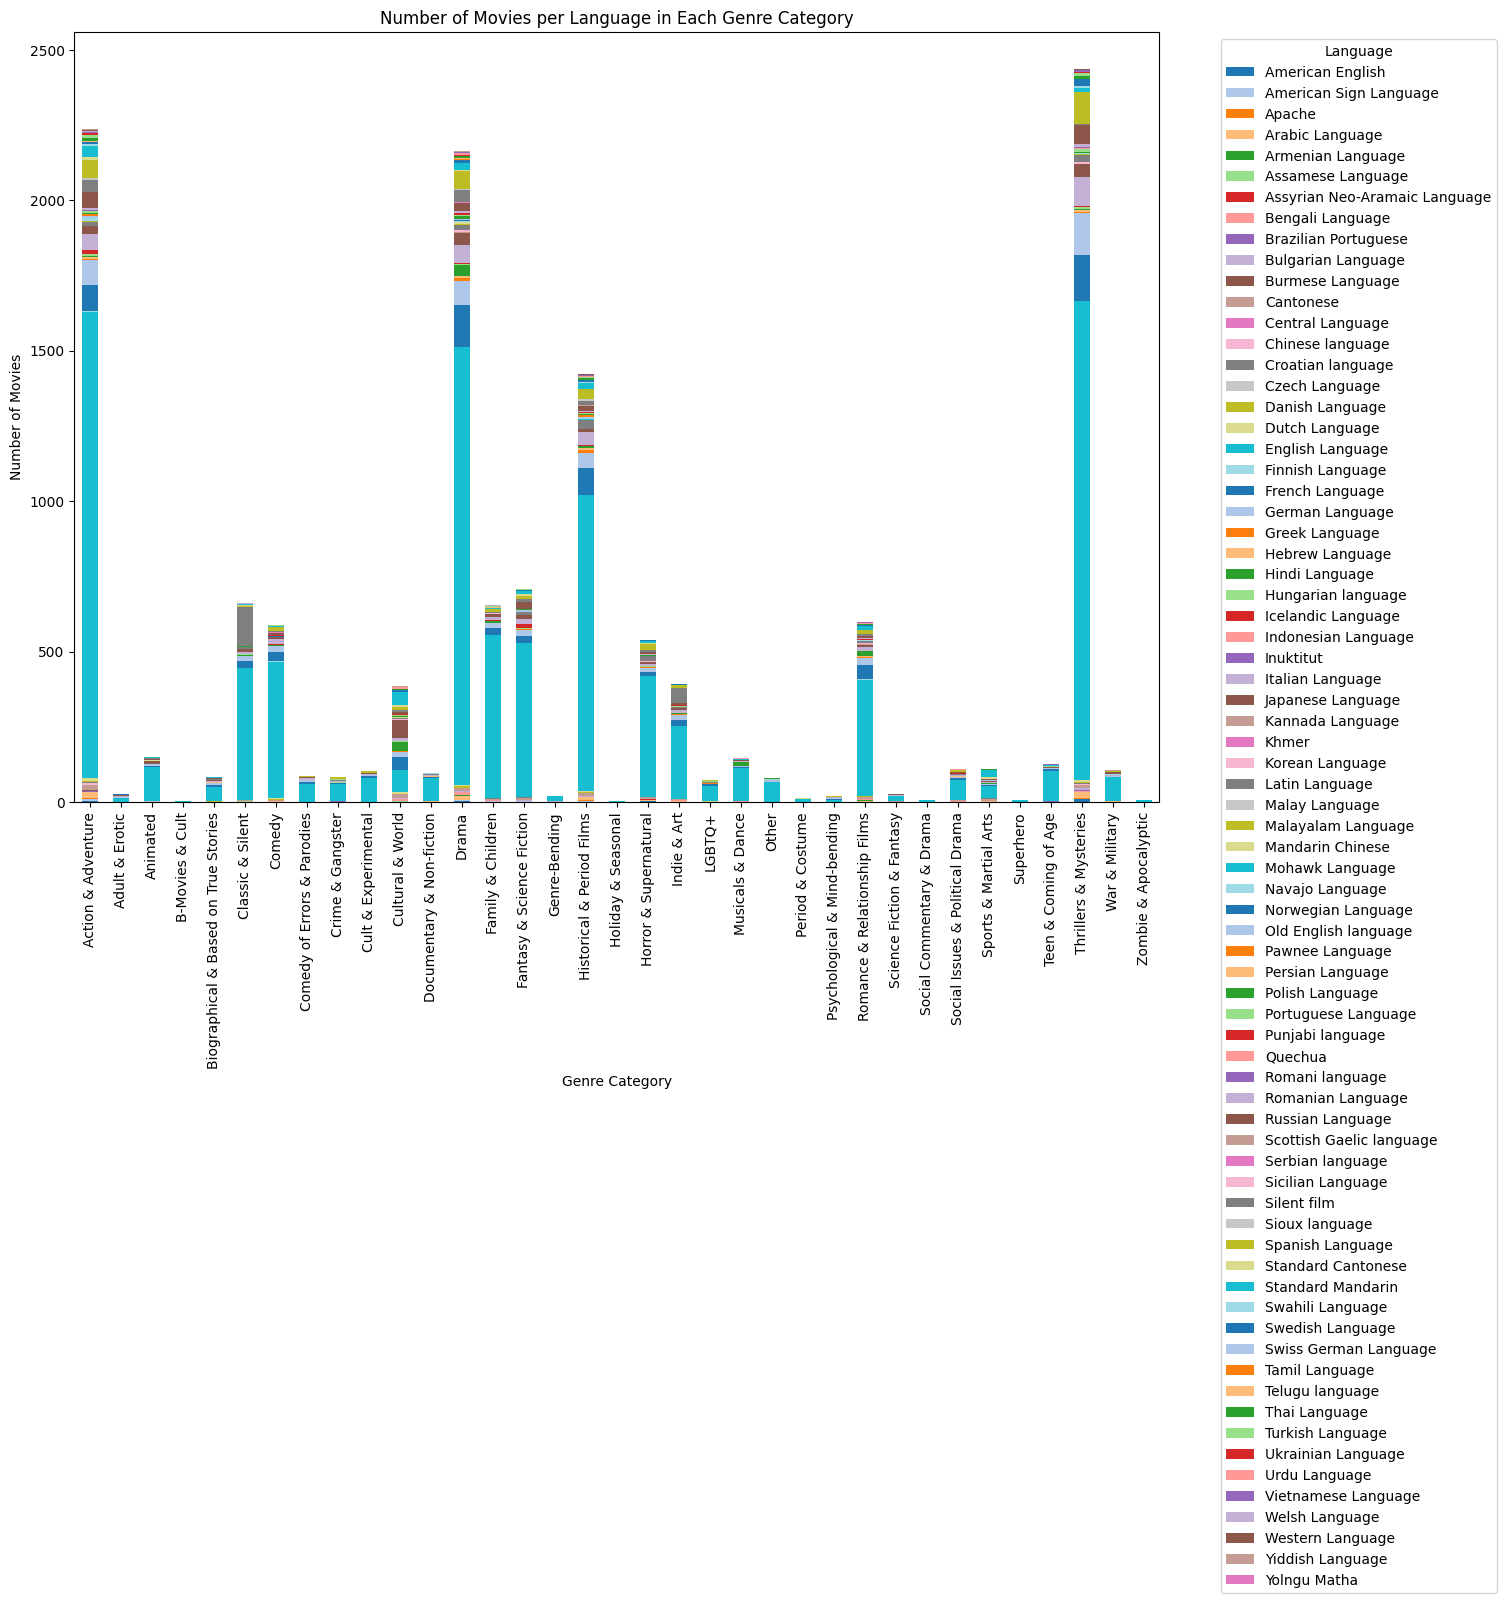

In [93]:
# Group by genre categories and languages, and count the number of movies in each combination
language_counts = df_genres_exploded_languages_exploded.groupby(['genres', 'language']).size().unstack()

# Map genres to categories
language_counts['category'] = language_counts.index.map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Group by genre categories and languages, and count the number of movies in each combination
language_counts = language_counts.groupby('category').sum()

# Plot the stacked bar chart
unique_languages = language_counts.columns[:-1]  # Exclude the 'category' column
colors = plt.cm.tab20.colors[:len(unique_languages)]  # Get a unique color for each language

language_counts[unique_languages].plot(kind='bar', stacked=True, figsize=(14, 10), color=colors)
plt.title('Number of Movies per Language in Each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

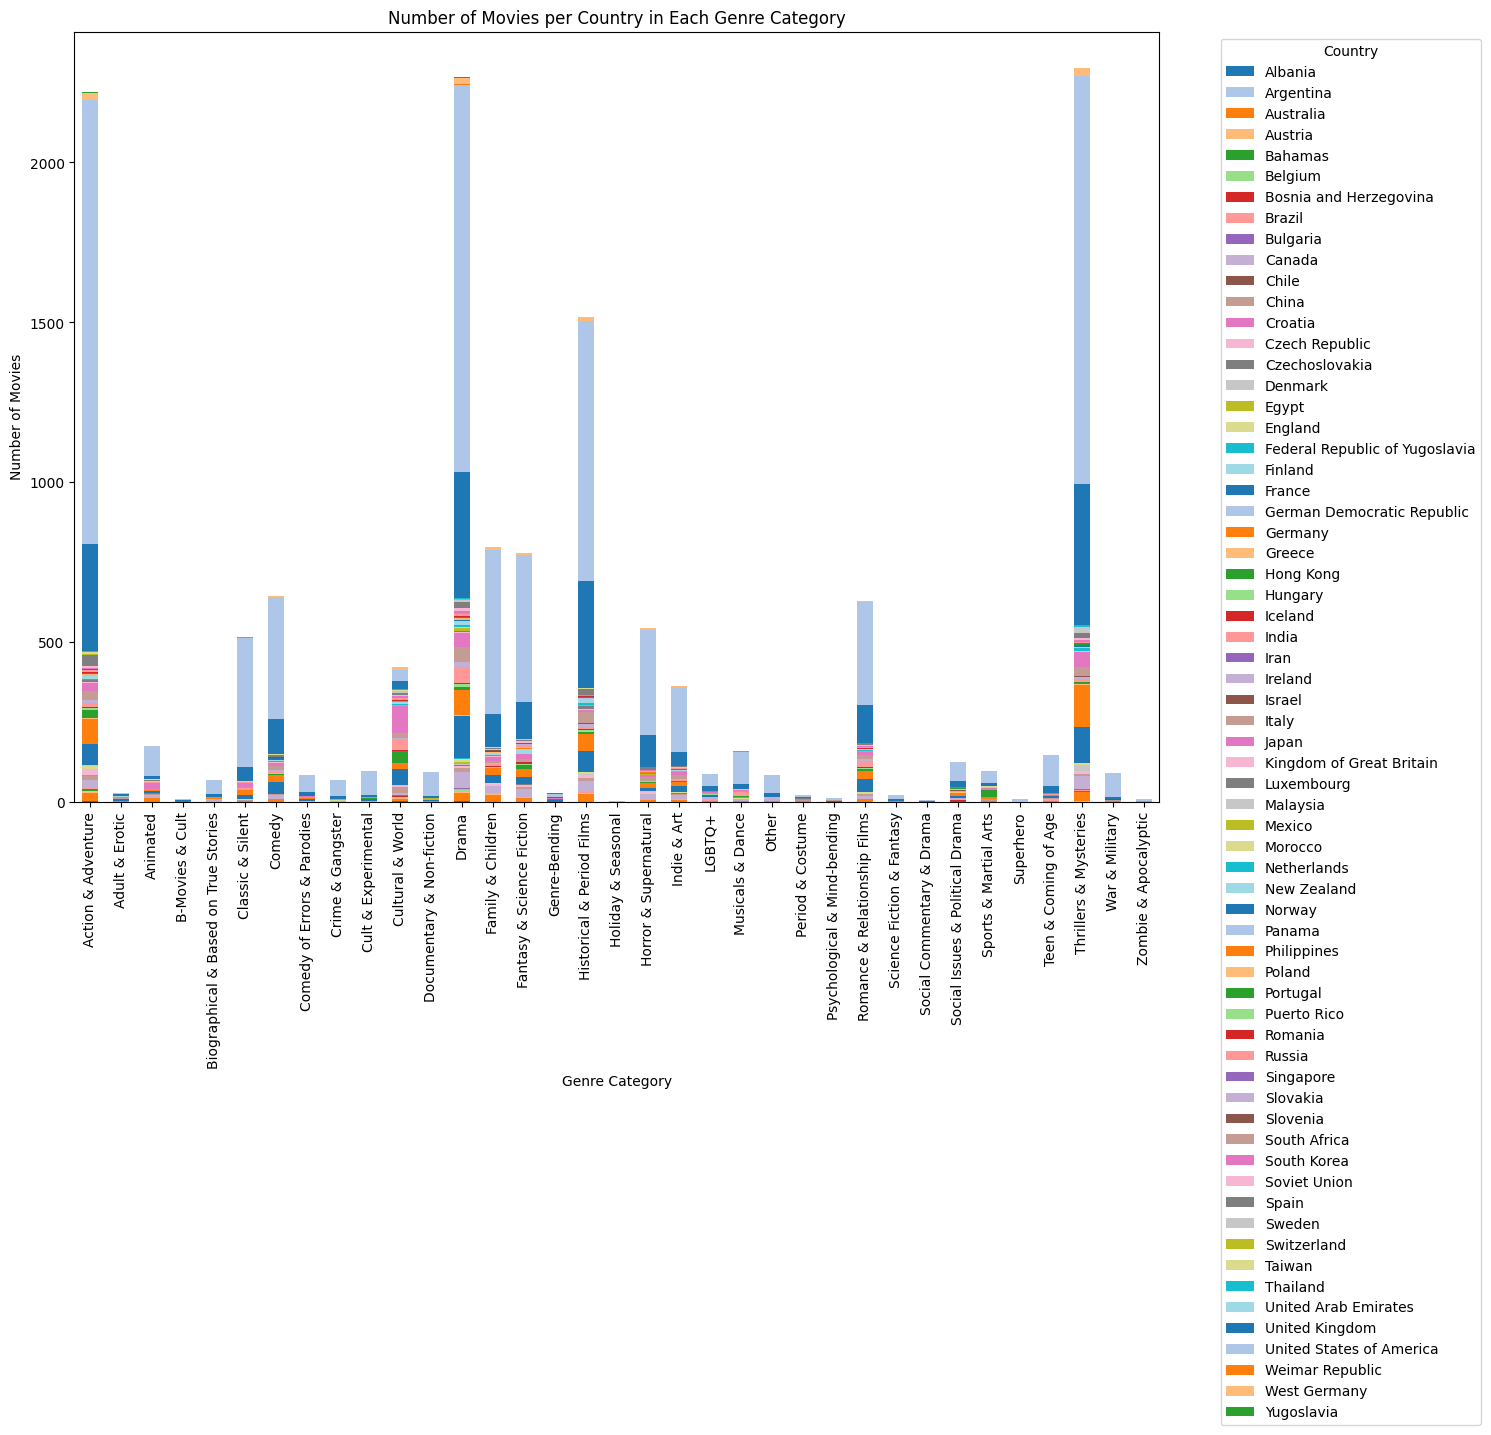

In [94]:
# Separate the countries by each comma and explode the list into separate rows
df_genres_exploded['countries'] = df_genres_exploded['countries'].str.split(', ')
df_genres_exploded_countries_exploded = df_genres_exploded.explode('countries')

# Group by genre categories and countries, and count the number of movies in each combination
country_counts = df_genres_exploded_countries_exploded.groupby(['genres', 'countries']).size().unstack()

# Map genres to categories
country_counts['category'] = country_counts.index.map(lambda x: next((k for k, v in genre_categories.items() if x in v), 'Other'))

# Group by genre categories and countries, and count the number of movies in each combination
country_counts = country_counts.groupby('category').sum()

# Plot the stacked bar chart
unique_countries = country_counts.columns[:-1]  # Exclude the 'category' column
colors = plt.cm.tab20.colors[:len(unique_countries)]  # Get a unique color for each country

country_counts[unique_countries].plot(kind='bar', stacked=True, figsize=(14, 10), color=colors)
plt.title('Number of Movies per Country in Each Genre Category')
plt.xlabel('Genre Category')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()